# Portfolio Optimization 

### Opgave 1: get_prices

Til delopgave 1 benyttes Google Finance modulets funktion get_price_data til at hente aktiekurser for fem forskellige aktier på specifikke kurser. Af hensyn til visualiseringen af aktiekurserne og deres ændringer over tid, hentes priser for aktier, hvis kurser ligger i nogenlunde samme størrelsesorden. get_price_data funktionen tager en dictionary som input, der består af fire parametre. get_prices funktionen defineres til at tage de samme inputs. I funktionen køres der et for-loop, da der arbejdes med en liste af aktier, er det nødvendigt at iterere over hver aktie.  

Funktionen, get_prices, har en tuple med to elementer som output: Første element, 'stocks', består af en liste over de aktier som vi inputter. Andet element, 'prices', er en matrix hvis søjler repræsenterer aktie $i$'s åbningskurser, hvor $j$'te indgang i søjlen angiver åbningskursen efter $j$ step_size's (hvor step_size er en parameter der angives i sekunder). Da det ønskes at transponerer matricen anvendes numpy-modulet på listen af lister 'prices' og på samme linie kode gøres matricen til en liste igen.

Til plottet laves der en legend, som angiver navnene på de aktier, som der hentes og plottes kurser for. Desuden roteres x-aksens indekser, for at gøre visualiseringen mere læsevenlig. 



In [55]:
import numpy as np
import matplotlib.pyplot as plt
from googlefinance.client import get_price_data

def get_prices(stocks, step_size, period, exchange):
    prices = []
    for stock in stocks:
        param = {
            'q': stock ,
            'i': step_size , 
            'x': exchange , 
            'p': period 
        }
        df = get_price_data(param)
        plt.plot(df['Open'], label = stock)
        
        price = df["Open"].tolist()                    #Liste af priser fra Stocks[j]
        prices.append(price)
        
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.xticks(rotation=45)
    plt.show()
    
    prices = np.array(prices).T.tolist() #Transponerer listen af priser, så det passer med kollonner af aktier
    
    stockprices = (stocks, prices)
    
    
    return stockprices
    

#get_prices(["VWS", "FLS", "ORSTED", "RBREW", "DFDS"], "86400", "1M", "CPH")
#get_prices(["AAPL", "FB", "EA", "VRTX", "ADBE"], "86400", "1M", "NASD")
#get_prices(["MCD", "IBM", "JNJ", "JPM", "DIS"], "86400", "1M", "NYSE")

### Opgave 2: $r$, $\mu$, $\Sigma$ og pdf'er
I delopgave 2 defineres funktionen 'parameters', hvor der startes med at at opdele inputtet 'stockprices'-tuplen ud i to variabler listen af lister 'prices' og listen 'stocks'. 

Der konstrueres en matrix $r \in \mathbb{R}^{mxn}$, hvor $m$ er antal aktier, og $n$ er antal step_sizes i den angivne periode. $r$ angiver procentvise prisændringer efter hvert step_size for hver aktie. $r$ konstrueres ved to for-loops, hvor der laves fractional reward lister i den første løkke og udregnes hver fractional reward (dvs. enkelte indgange i matricen) i anden løkke. Desuden benyttes round()-funktionen, da der ellers ville fås meget lange floating points. 

Næste parameter, der udregnes, er middelværdierne af prisændringerne for aktierne $\mu$. Hvor $\mu_i$ angiver middelværdien af prisændringerne for den $i$'te aktie. Igen startes der med en summeret $\mu$-liste, hvor der itereres over alle aktier og i hver iteration summeres og deles der med $n$ over alle tidsperioder for at finde middelværdien af den $i$'te aktie. 

Dernæst beregnes covariansmatricen $\Sigma$, hvori den $i,j$'te indgang er covariansen af prisændringerne for den $i$'te og den $j$'te aktie. Indgangene i diagonalen (de $i,i$'te indgange) består således blot af varianserne for aktierne. Dette gøres i koden ved først og fremmest at benytte numpy til at transponerer prisændringsmatricen $r$, da det til udregningen af $\Sigma$, er en fordel at hver række repræsenterer prisændringerne for hver aktie. I et enkelt for-loop trækkes middelværdierne $\mu_i$ fra indgangene i hver akties prisændringer. Dette giver en ny matrix, som defineres ved r_minus_mu. Covariansmatricen fås da ved at multiplicere r_minus_mu matricen sammen med dens transponerede, hvilket gøres med np.dot()-funktionen fra numpy-modulet.

Til plottene af pdf'erne itereres der over hver aktie hvor i hver iteration konstruerer et linearrum med aktiens middelværdi som centrum og går 3 standardafvigelser ud til hver side vha. sqrt()-funktionen fra math-modulet. Derefter benyttes normpdf()-funktionen fra matplotlib.mlab-modulet på linearrummet og tilføjer relevante x-og-y-akse labels samt en legend med aktienavne. 

Slutteligt returneres der i alt fire parametre: $r$-matricen, $\mu$-vektoren, covariansmatricen $\Sigma$ samt listen af aktier, 'stocks', da sidstnævnte også skal benyttes i delopgave 3.




In [56]:
from math import sqrt
from matplotlib.mlab import normpdf

def parameters(stockprices):
    prices = stockprices[1]
    stocks = stockprices[0]
    
    r = []
    for j in range(len(prices)-1):
        frac_reward_row = []
        for i in range(len(prices[j])):
            frac_reward = (prices[j+1][i] - prices[j][i]) / prices[j+1][i]
            frac_reward = round(frac_reward, 4)
            frac_reward_row.append(frac_reward)
        r.append(frac_reward_row)
    
    
    n = len(r)
    mu = []
    for i in range(len(prices[0])): #lige mange indgange
        mu_i = 0
        for j in range(n):
            mu_i += r[j][i] / n
            mu_i = round(mu_i, 5)
        mu.append(mu_i)
    
    r_transposed = np.array(r).T
    r_minus_mu_list = []
    for i in range(len(r_transposed)):
        r_minus_mu_i = r_transposed[i]-mu[i]
        r_minus_mu_list.append(r_minus_mu_i)
         
    r_minus_mu , r_minus_mu_T = np.array(r_minus_mu_list) , np.array(r_minus_mu_list).T
        
    sigma = np.dot(r_minus_mu , r_minus_mu_T)
    sigma = np.matrix.round(sigma, 5)
    
    m = len(mu) #antal aktier
    for i in range(m):
        x = np.linspace(mu[i] - 3*sqrt(sigma[i][i]), mu[i] + 3*sqrt(sigma[i][i]), 100)
        plt.plot(x, normpdf(x, mu[i], sqrt(sigma[i][i])), label = stocks[i])    
    plt.xlabel(s= "Expected Returns")
    plt.ylabel(s= "Frequency")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Stocks:")
    plt.show()
    
    return r , mu , sigma, stocks
        

#parameters(get_prices(["VWS", "FLS", "ORSTED", "RBREW", "DFDS"], "86400", "2M", "CPH"))
#parameters(get_prices(["AAPL", "FB", "EA", "VRTX", "ADBE"], "86400", "1M", "NASD"))
#parameters(get_prices(["MCD", "IBM", "JNJ", "JPM", "DIS"], "86400", "1M", "NYSE"))
                

### Opgave 3: Optimering, pdf'er og scatter plot
I sidste delopgave løses det angivne maksimeringsproblem. Problemet har en lighedsbegrænsning, så der kan f.eks. benyttes metoden SLSQP fra minimize()-funktionen i scipy.optimize-modulet. Foruden løsningen af problemet, skulle der plottes pdf'er for forskellige værdi af $\gamma$, en værdi, som angiver hvor risiko-avers en agent er. Derudover skulle der konstrueres et scatter-plot for de forskellige optimalløsninger $w^*$ givet en $\gamma$-værdi. 

Alt dette løses under en paraply-funktion solve_and_plot(), som tager parametrene fra delopgave 2 som input. Under denne funktion defineres maximize(), som angiver objektfunktionen, hvori der benyttes multi_dot() til at multiplicere de to vektorer på covariansmatricen, så fås et tal samt con()-funktionen, som definerer bibetingelsen, der skal sikre at indgangene i løsningsvektoren $w^*$ summerer til 1. 

Pdf'erne plottes og optimeringsproblemet løses for hver $\gamma$-værdi med et for-loop, hvori der startes med en basisløsning/initialløsning w0, som der defineres ved at bruge alt på sidste aktie. Med denne initialløsning som udgangspunkt benyttes minimize()-funktionen med de nødvendige inputs tidligere defineret. Herfra udtrækkes løsningsvektoren $w^*$ som array fra resultatet af optimeringsproblemet. Derefter plottes pdf'en, nogenlunde på samme måde som i delopgave 2, for hver $\gamma$-værdi samt den tilhørende løsningsvektor $w^*$. 

Til scatter-plottet laves der en liste af farver colors med samme antal indgange, som der er aktier. Der itereres igen over hver $\gamma$-værdi, hvor optimeringsproblemet løses. For kun at give et label per aktie, laves der for-loop med if-else statements, der sikrer at der kun gives et label per aktie i plottets legend.



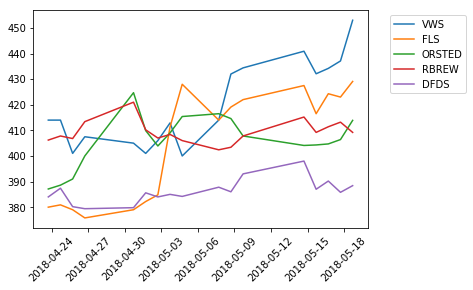

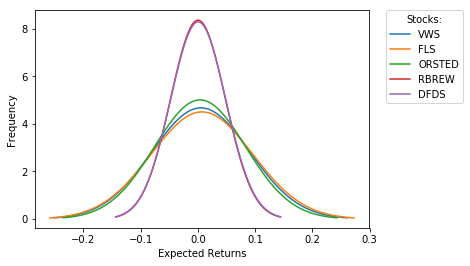

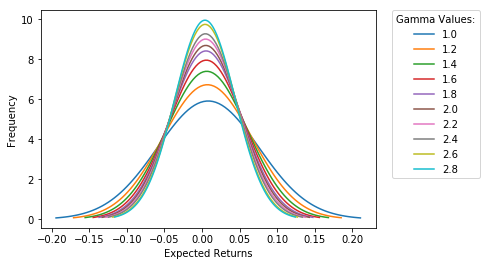

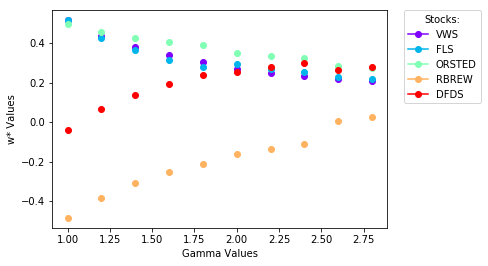

In [57]:
import matplotlib
from scipy.optimize import minimize
from numpy.linalg import multi_dot


def solve_and_plot(parameters):
    gammas = (np.arange(10) / 5) + 1 
    mu = np.array(parameters[1])
    sigma = np.array(parameters[2])
    stocks = parameters[3]
    n = len(mu)
    
    def maximize(x):
        function = gamma * multi_dot([x.T , sigma , x]) - np.dot(x.T , mu) 
        # Bruger funktionen minimize, så ganger igennem med minus da der skal maksimeres
        return function
    
    def con(x):
        return sum(x) - 1
    cons = {'type':'eq', 'fun': con}
    
    for gamma in gammas:
       w0 = np.array([0] * (n-1) + [1]) #basisløsning alt på én
       res = minimize(maximize, w0, method='SLSQP', constraints = cons)
       w_star = res.x
       x = np.linspace(np.dot(w_star.T , mu) - 3*sqrt(multi_dot([w_star.T , sigma , w_star])), 
            np.dot(w_star.T , mu) + 3*sqrt(multi_dot([w_star.T , sigma , w_star])), 100)
       plt.plot(x, normpdf(x, np.dot(w_star.T , mu), sqrt(multi_dot([w_star.T , sigma , w_star]))), 
                label = gamma)  
    plt.xlabel(s= "Expected Returns")
    plt.ylabel(s= "Frequency")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Gamma Values:")
    plt.show()
    
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(w_star)))
    for gamma in gammas:
       w0 = np.array([0] * (n-1) + [1])
       res = minimize(maximize, w0, method='SLSQP', constraints = cons)
       w_star = res.x
       
       for i in range(len(w_star)):
           if gamma==gammas[0]:
               label = stocks[i] 
           else:
               label = None
           plt.plot(gamma, w_star[i], marker='o', color=colors[i], label = label)
           
    plt.xlabel(s= "Gamma Values")
    plt.ylabel(s= "w* Values")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Stocks:")
    plt.show()
    
    

solve_and_plot(parameters(get_prices(["VWS", "FLS", "ORSTED", "RBREW", "DFDS"], "86400", "1M", "CPH")))
#solve_and_plot(parameters(get_prices(["AAPL", "FB", "EA", "VRTX", "ADBE"], "86400", "1M", "NASD")))
#solve_and_plot(parameters(get_prices(["MCD", "IBM", "JNJ", "JPM", "DIS"], "86400", "1M", "NYSE")))


### Afsluttende refleksion

Gennemgående i projektet er der anvendt viden fra Lineær Algebra, Matematisk Modellering og Optimering, som er tilegnet tidligere på studiet. Et at de svære områder i dette projekt har især været forståelsen i anvendelsen af metoderne fra Lineær Algebra, specifikt konstruktionen af vektorer og matricer med for-løkker samt multiplicére dem sammen på korrekt vis med numpy-modulet. 

Dele af projektet, der kunne forbedres, ville evt. være at gemme optimeringsresultatet i en liste under delopgave 3, så det ikke behøves at blive udregnet igen under anden for-løkke, hvor der laves scatter-plot. Denne liste med optimeringsresultatet ville man da kunne refererer til under begge for-løkker i forbindelse med konstruktionen af både pdf'erne samt scatter-plottet. 

En mangel i projektet eller endnu et område der kunne forbedres ville være i visualiseringen af vores diverse plots, hvor det kunne gøres mere konsistent og læsevenligt at have beholdt den samme farve for hver aktie, under scatter-plottet som blev tildelt i plottene af aktiekursernes prisændringer og pdf'er. 

Slutteligt menes projektet samlet set at have været relevant for Matematik-Økonomi studiet.